In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from rdkit import Chem
import plotly.express as px
import XAIChem

In [2]:
# Load data sets
esol_df = pd.read_csv("../../data/ESOL/ESOL.csv")
attributions_functional_groups = pd.read_json("../../data/ESOL/attribution_functional_groups_around_mean.json").drop(
    columns=["time_SME", "time_HN_value", "time_Shapley_value"]
)
attributions_brics = pd.read_json("../../data/ESOL/attribution_brics_around_mean.json").drop(
    columns=["time_SME", "time_HN_value", "time_Shapley_value"]
)

In [3]:
# Load trained models
model, config = XAIChem.models.PreBuildModels.rgcnWuEtAll("../scripts/esol/model_config.yaml", ["seed"], model_id=0)

paths = [
    f"../../data/ESOL/trained_models/rgcn_model_{model_id}_early_stop.pt"
    for model_id in range(10)
]

models = XAIChem.loadModels(model, paths)

# Explain prediction

In [4]:
def predict_water_solubility(smiles):

    graph = XAIChem.createDataObjectFromSmiles(smiles, np.inf)
    
    experimental_solubility = esol_df.query("smiles == @smiles").ESOL.iloc[0]
    predicted_solubility = XAIChem.predict(graph, models).item()

    return experimental_solubility, predicted_solubility

In [27]:
def prediction_errors(substruct_smiles, attribution_method):
    """
    Selects all molecules containing the given substructure which have a chemically inconsistent 
    attribution according to the given method. Then, determine the fraction of molecules that 
    have an absolute prediction error larger than 0.6 (comparable with experimental error)
    """
    predictions = defaultdict(list)

    if attribution_method is not None:
        smiles_list = attributions_functional_groups.query(
            f"substruct_smiles == @substruct_smiles and {attribution_method}"
        ).molecule_smiles.unique()

    else:
        smiles_list = attributions_functional_groups.query(
            f"substruct_smiles == @substruct_smiles"
        ).molecule_smiles.unique()
    
    for smiles in smiles_list:
        experimental_solubility, predicted_solubility = predict_water_solubility(smiles)
        
        predictions["smiles"].append(smiles)
        predictions["experimental_solubility"].append(experimental_solubility)
        predictions["predicted_solubility"].append(predicted_solubility)

    predictions = pd.DataFrame.from_dict(predictions)
    predictions["diff"] = np.abs(predictions.experimental_solubility - predictions.predicted_solubility)
    fraction_wrong_predictions = len(predictions.query("diff > 0.6")) / len(predictions)
    print(f"{fraction_wrong_predictions = }")

    display(predictions.query("diff > 0.6"))
    display(predictions.query("diff <= 0.6"))

In [6]:
def explain(smiles):

    experimental_solubility, predicted_solubility = predict_water_solubility(smiles)

    print(f"{experimental_solubility = }")
    print(f"{predicted_solubility = }")
    
    explanation = attributions_functional_groups.query("molecule_smiles == @smiles").copy()
    explanation["atom_ids"] = explanation.atom_ids.apply(tuple)
    
    sme_explanation = explanation[["atom_ids", "SME"]].set_index("atom_ids").SME.round(2).to_dict()
    HN_explanation = explanation[["atom_ids", "HN_value"]].set_index("atom_ids").HN_value.round(2).to_dict()
    Shapley_explanation = explanation[["atom_ids", "Shapley_value"]].set_index("atom_ids").Shapley_value.round(2).to_dict()

    rdmol = Chem.MolFromSmiles(smiles)
    
    print("SME")
    display(XAIChem.showMolecule(rdmol, atoms_highlight_values=sme_explanation))
    
    print("Shapley value")
    display(XAIChem.showMolecule(rdmol, atoms_highlight_values=Shapley_explanation))
    
    print("HN value")
    display(XAIChem.showMolecule(rdmol, atoms_highlight_values=HN_explanation))

## Erythritol

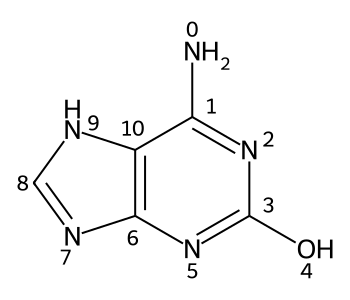

In [42]:
erythritol_smiles = 'Nc1nc(O)nc2nc[nH]c12'
erythritol_rdmol = Chem.MolFromSmiles(erythritol_smiles)

XAIChem.showMolecule(erythritol_rdmol, show_atom_indices=True)

experimental_solubility = -3.401
predicted_solubility = -2.500154972076416
SME


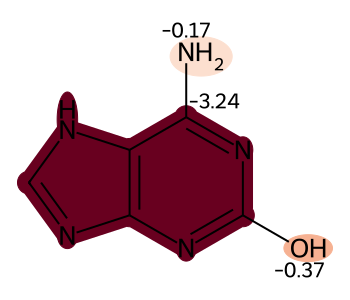

Shapley value


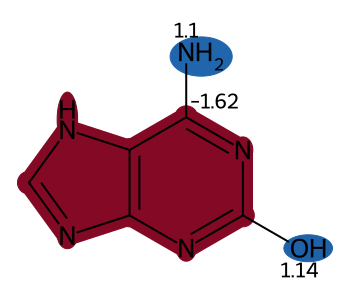

HN value


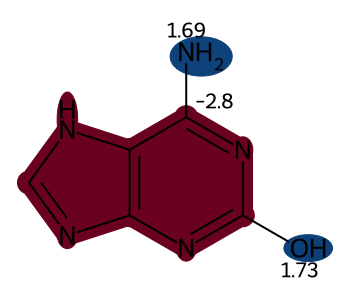

In [41]:
explain(erythritol_smiles)

The predicted solubility is not equal to the experimental solubility of the data set. This difference
could be explained using different attribution techniques (i.e. SME, Shapley value and HN value). From 
chemical theory it is known that hydroxyl group improve the solubility while apolar carbon chains are 
porly soluble. Therefore it is expected that the hydroxyl groups have a positive attribution while the 
carbon chain has a negative or slightly positive attribution.

Both SME and Shapley attributions are in conflict with chemical intuition and could explain why the model predicts a 
to long solubility. However, the HN attributions do result chemical correct attribution methods. This raises the question 
wheter the HN explanation is incorrect and the incorrect prediction can be explained by the Shapley and SME attributions,
or the HN explanation is correct and the failure of the model is due to another reason.

## Mol 2

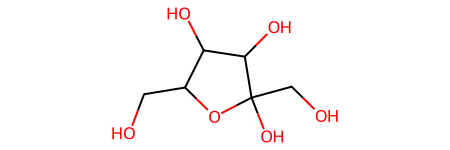

In [24]:
smiles = "OCC1OC(O)(CO)C(O)C1O"
rdmol = Chem.MolFromSmiles(smiles)
graph = XAIChem.createDataObjectFromRdMol(rdmol, np.inf)

rdmol

experimental_solubility = 0.64
predicted_solubility = 0.40207815170288086
SME


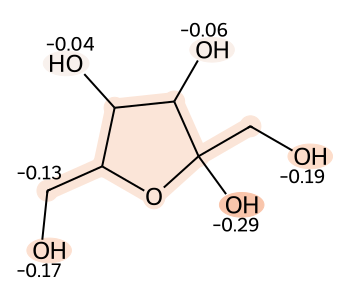

Shapley value


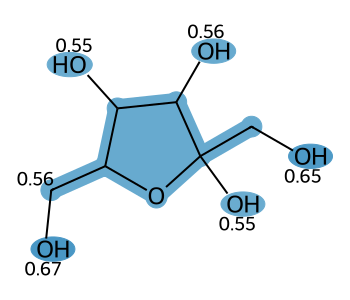

HN value


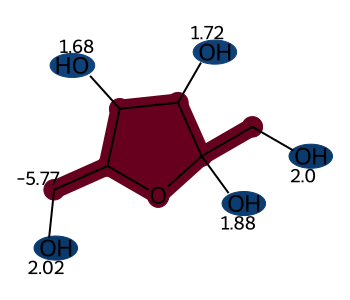

In [25]:
explain(smiles)

# Functional groups with wrong predictions

In [29]:
prediction_errors("ROH", None)

fraction_wrong_predictions = 0.12393162393162394


,smiles,experimental_solubility,predicted_solubility,diff
1,CC1CCC(C(C)C)C(O)C1,-2.530,-4.155624,1.625624
12,C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C,-4.300,-5.215076,0.915076
13,CC12CCC(=O)C=C1CCC1C2CCC2(C)C(O)CCC12,-4.020,-4.663515,0.643515
17,OCC1OC(OCC2OC(OC3(CO)OC(CO)C(O)C3O)C(O)C(O)C2O...,-0.410,0.306231,0.716231
37,C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C,-5.660,-4.850834,0.809166
42,Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl,-4.460,-5.174350,0.714350
59,Oc1c2ccccc2cc2ccccc12,-4.730,-4.083386,0.646614
62,CO,1.570,0.928259,0.641741
69,Nc1nc(O)nc2nc[nH]c12,-3.401,-2.500155,0.900845
71,Oc1cccc2cccnc12,-2.420,-1.801126,0.618874


,smiles,experimental_solubility,predicted_solubility,diff
0,O=C1Nc2ccc(Cl)cc2C(c2ccccc2Cl)=NC1O,-3.604,-3.889950,0.285950
2,COC1=CC2OC3C=CC(O)=CC3C(=O)C2C(O)=C1,-2.943,-3.189878,0.246878
3,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-4.081,-4.545399,0.464399
4,CCC(C)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,-3.380,-3.858643,0.478643
5,OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F,-1.800,-1.528953,0.271047
...,...,...,...,...
227,CCCC(C)(C)CO,-1.520,-1.422146,0.097854
228,CC(=O)C1(O)CCC2C3CC(C)C4=CC(=O)C=CC4(C)C3(F)C(...,-4.099,-4.195755,0.096755
231,CC12CCC(=O)C=C1CCC1C2CCC2(C)C(C(=O)CO)CCC12,-3.450,-3.719813,0.269813
232,CCC(CC)CO,-1.170,-0.997089,0.172911


In [21]:
prediction_errors("ROH", "SME < 0")

fraction_wrong_predictions = 0.3125


,smiles,experimental_solubility,predicted_solubility,diff
2,Nc1nc(O)nc2nc[nH]c12,-3.401,-2.500155,0.900845
3,Oc1cccc2cccnc12,-2.420,-1.801126,0.618874
4,Oc1cccc2ncccc12,-2.540,-1.793547,0.746453
9,OCC(O)C1OC2OC(C(Cl)(Cl)Cl)OC2C1O,-1.840,-1.124054,0.715946
12,CCCCCCCCCCCCCCCCCCO,-8.400,-7.405501,0.994499


,smiles,experimental_solubility,predicted_solubility,diff
0,O=C1CC(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21,-3.620,-3.286066,0.333934
1,OCC(O)C(O)CO,0.700,0.432186,0.267814
5,OC1COC(O)C(O)C1O,0.390,0.775286,0.385286
6,CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O,-4.160,-4.154682,0.005318
7,OCC1OC(O)(CO)C(O)C1O,0.640,0.402078,0.237922
8,Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c...,-3.685,-3.548808,0.136192
10,OCC1OC(O)C(O)C(O)C1O,0.740,0.763188,0.023188
11,OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O,-0.244,0.290772,0.534772
13,Oc1ncc2nccnc2n1,-1.947,-1.653501,0.293499
14,Nc1ncnc2c1ccn2C1OC(CO)C(O)C1O,-1.950,-1.662153,0.287847


In [39]:
for smiles in attributions_functional_groups.query(
    f"substruct_smiles == 'ROH' and SME <= 0"
).molecule_smiles.unique():

    entry = esol_df.query("smiles == @smiles")
    print(f"{entry.smiles.iloc[0]}: {entry.group.iloc[0]}")

O=C1CC(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21: training
OCC(O)C(O)CO: valid
Nc1nc(O)nc2nc[nH]c12: test
Oc1cccc2cccnc12: training
Oc1cccc2ncccc12: training
OC1COC(O)C(O)C1O: training
CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O: training
OCC1OC(O)(CO)C(O)C1O: test
Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C: training
OCC(O)C1OC2OC(C(Cl)(Cl)Cl)OC2C1O: training
OCC1OC(O)C(O)C(O)C1O: training
OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O: training
CCCCCCCCCCCCCCCCCCO: training
Oc1ncc2nccnc2n1: training
Nc1ncnc2c1ccn2C1OC(CO)C(O)C1O: training
OCC(O)CO: valid


In [189]:
prediction_errors("R=S", "SME < 0")

fraction_wrong_predictions = 0.36363636363636365


,smiles,experimental_solubility,predicted_solubility,diff
6,CCN1c2ncccc2C(=S)N(C)c2cccnc21,-4.634,-4.182835,0.451165
7,C=CCC1(C(C)CCC)C(=O)NC(=S)NC1=O,-3.460,-3.083044,0.376956
8,CN(C)C(=S)SSC(=S)N(C)C,-3.900,-3.136156,0.763844
9,CCN(CC)C(=S)SSC(=S)N(CC)CC,-4.860,-4.346002,0.513998


In [204]:
prediction_errors("R-C(=O)OCH3", "Shapley_value > 0")

fraction_wrong_predictions = 0.1111111111111111


,smiles,experimental_solubility,predicted_solubility,diff
5,COCC(=O)N(c1c(C)cccc1C)C(C)C(=O)OC,-1.601,-2.833154,1.232154
17,COC(=O)c1ccccc1OC1OC(COC2OCC(O)C(O)C2O)C(O)C(O...,-0.742,-1.363291,0.621291


experimental_solubility = -0.742
predicted_solubility = -1.3632909059524536
SME


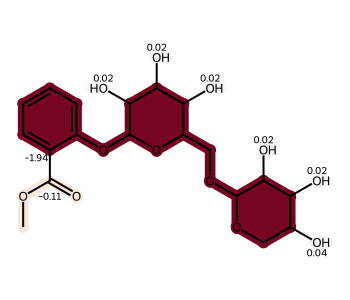

Shapley value


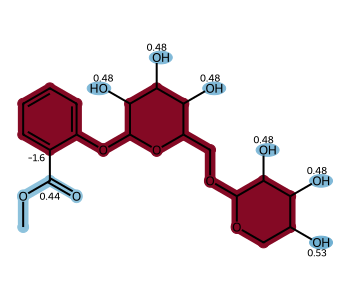

HN value


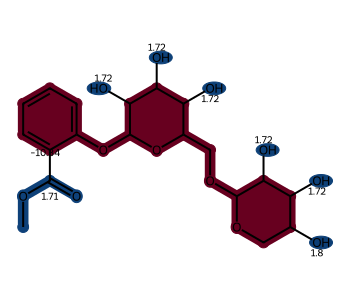

In [27]:
explain("COC(=O)c1ccccc1OC1OC(COC2OCC(O)C(O)C2O)C(O)C(O)C1O")

In [194]:
esol_df.query("smiles == 'CC(=O)C(C)C'")

,smiles,ESOL,group
960,CC(=O)C(C)C,-0.12,training


In [12]:
esol_df.loc[171]

smiles    CC(=O)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
ESOL                                        -4.65
group                                    training
Name: 171, dtype: object

In [24]:
fg_groups = ["ROH", "R-C(=O)CH3"]
def selector(x):
    substructures = x.substruct_smiles.values
    if "ROH" in substructures and "R-C(=O)OCH3" in substructures:
        return 1

    return 0

attributions_functional_groups.groupby("molecule_smiles").apply(selector).to_frame("N").query("N == 1")

,N
molecule_smiles,
COC(=O)c1cc(O)c(O)c(O)c1,1
COC(=O)c1ccc(O)cc1,1
COC(=O)c1ccccc1OC1OC(COC2OCC(O)C(O)C2O)C(O)C(O)C1O,1


In [21]:
fg_groups = ["ROH", "R-C(=O)CH3"]
def selector(x):
    substructures = x.substruct_smiles.values
    if "ROH" in substructures and "R=O" in substructures:
        return 1

    return 0

attributions_functional_groups.groupby("molecule_smiles").apply(selector).sum()

62

In [29]:
test_attributions = pd.read_json("../../data/ESOL/test_attributions_around_mean.json")
test_attributions.head()

,molecule_smiles,group,atom_ids,functional_group,masked_prediction,SME,non_masked_prediction,time_SME,HN_value,time_HN_value,Shapley_value,time_Shapley_value,substruct_smiles,ESOL
0,BrCCBr,fg,[0],RX,-1.365084,-0.294411,-1.659495,0.467680,1.202001,0.042732,0.686595,0.030586,None,-1.68
1,BrCCBr,fg,[3],RX,-1.365084,-0.294411,-1.659495,0.467680,1.202000,0.042732,0.686595,0.030586,None,-1.68
2,BrCCBr,fg,"[1, 2]",scaffold,-0.808419,-0.851076,-1.659495,0.467680,-0.936767,0.042732,0.094045,0.030586,None,-1.68
3,Brc1cc(Br)c(Br)cc1Br,fg,[0],RX,-6.303532,-0.206526,-6.510058,0.535912,1.271198,0.032272,0.322045,0.020008,None,-6.98
4,Brc1cc(Br)c(Br)cc1Br,fg,[4],RX,-6.303532,-0.206526,-6.510058,0.535912,1.271198,0.032272,0.322045,0.020008,None,-6.98


In [39]:
print(len(test_attributions.query("functional_group == 'R=S'")[["SME", "Shapley_value", "HN_value"]]))

(test_attributions.query("functional_group == 'R-tBu'")[["SME", "Shapley_value", "HN_value"]] < 0).sum()

1


SME              2
Shapley_value    2
HN_value         2
dtype: int64

# Manual ranks

In [43]:
df = pd.read_csv("../../data/ESOL/manual_vs_attribution_rank_correlations_around_mean.csv")
df.head()

,Unnamed: 0,smiles,prediction,ESOL,absolute_error,absolute_error_class,SME_rank_corr,Shapley_rank_corr,HN_rank_corr
0,0,BrCCBr,-1.659495,-1.68,0.020505,< 0.6,1.0,1.0,0.866025
1,3,Brc1cc(Br)c(Br)cc1Br,-6.510058,-6.98,0.469942,< 0.6,1.0,1.0,1.000000
2,8,Brc1cccc(Br)c1,-4.152843,-3.54,0.612843,>= 0.6,1.0,1.0,1.000000
3,11,Brc1cccc2ccccc12,-4.388748,-4.35,0.038748,< 0.6,1.0,1.0,1.000000
4,13,C#CCCCCCCC,-4.244354,-4.24,0.004354,< 0.6,1.0,1.0,1.000000


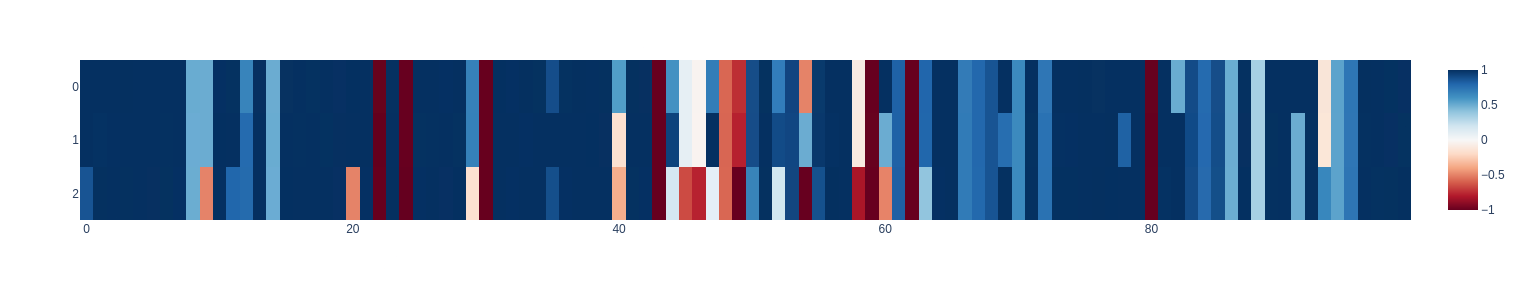

In [63]:
fig = px.imshow(
    df[["SME_rank_corr", "Shapley_rank_corr", "HN_rank_corr"]].values.T,
    color_continuous_scale="RdBu",
    aspect="auto",
    width=1200,
    height=300,
)
fig.show()

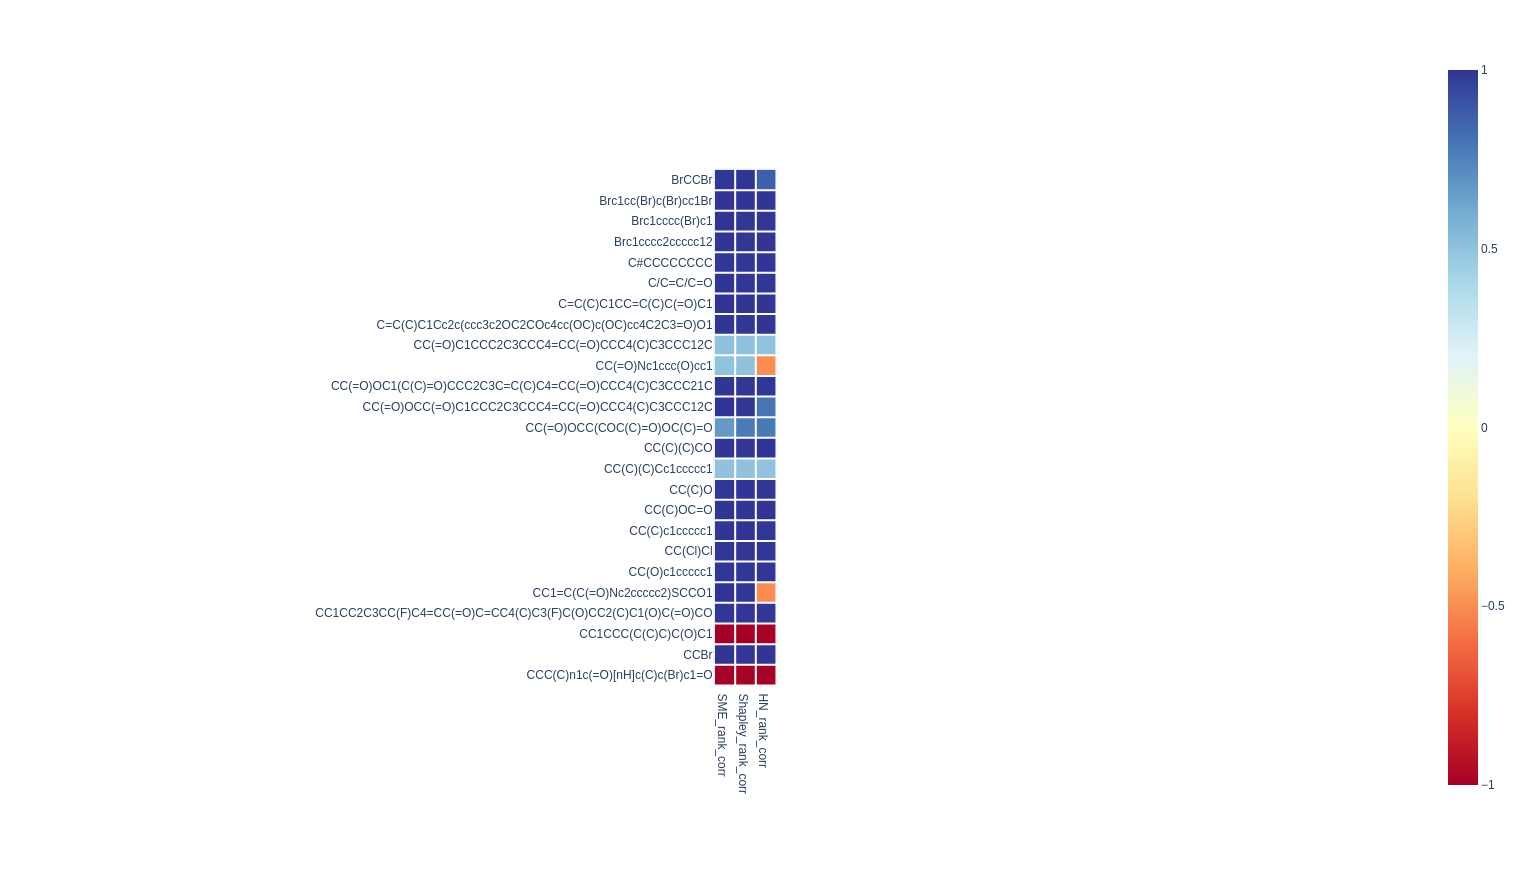

In [78]:
hm = df[["SME_rank_corr", "Shapley_rank_corr", "HN_rank_corr"]].iloc[:25]

cell_size = 35
row_title_width = 300
width = cell_size*len(hm.columns) + row_title_width
height = cell_size*len(hm.index)

fig = px.imshow(hm, width=width, height=height, y=df.smiles.iloc[:25], color_continuous_scale='RdYlBu')

for i in range(len(hm.columns)):
    fig.add_shape(type="line", x0=0.5 + i, y0=-0.5, x1=0.5 + i, y1=len(hm.index) - 0.5, line=dict(color="white", width=2))

for i in range(len(hm.index)):
    fig.add_shape(type="line", x0=-0.5, y0=0.5 + i, x1=len(hm.columns) - 0.5, y1=0.5 + i, line=dict(color="white", width=2))

fig.show()

In [82]:
df[["smiles", "SME_rank_corr", "Shapley_rank_corr", "HN_rank_corr"]].iloc[:25]

,smiles,SME_rank_corr,Shapley_rank_corr,HN_rank_corr
0,BrCCBr,1.000000,1.000000,0.866025
1,Brc1cc(Br)c(Br)cc1Br,1.000000,1.000000,1.000000
2,Brc1cccc(Br)c1,1.000000,1.000000,1.000000
3,Brc1cccc2ccccc12,1.000000,1.000000,1.000000
4,C#CCCCCCCC,1.000000,1.000000,1.000000
5,C/C=C/C=O,1.000000,1.000000,1.000000
6,C=C(C)C1CC=C(C)C(=O)C1,1.000000,1.000000,1.000000
7,C=C(C)C1Cc2c(ccc3c2OC2COc4cc(OC)c(OC)cc4C2C3=O)O1,1.000000,1.000000,1.000000
8,CC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,0.500000,0.500000,0.500000
9,CC(=O)Nc1ccc(O)cc1,0.500000,0.500000,-0.500000


In [105]:
cols = [
    df[["SME_rank_corr", "Shapley_rank_corr", "HN_rank_corr"]].iloc[i * 25: (i + 1) * 25].values
    for i in range(4)
]

# for row in zip(*cols):

#     row_str = f""

#     for molecule in row:
#         row_str += str(molecule[0]) + " \t "
        
#         for j in range(1, 4):
#             row_str += str(round(molecule[j], 2)) + " "

#         row_str += " \t "
    
#     print(row_str)
#     print("#####")

In [118]:
cols

[array([[ 1.        ,  1.        ,  0.8660254 ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.5       ,  0.5       , -0.5       ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  0.8       ],
        [ 0.66666667,  0.77777778,  0.77777778],
        [ 1.        ,  1.        ,  1.        ],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        

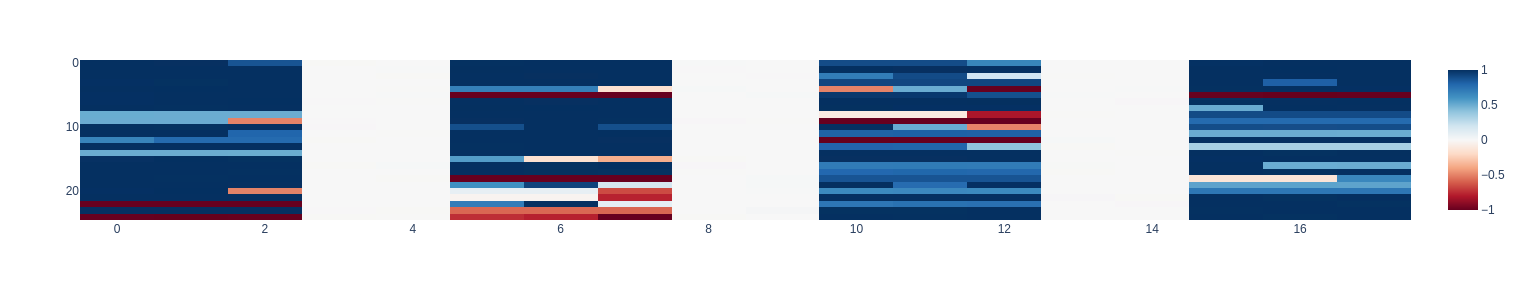

In [142]:
A = np.asarray(list(zip(*cols))).reshape(25, 12)
A = np.insert(A, [3, 6, 9], 0, axis=1)
A = np.insert(A, [3, 7, 11], 0, axis=1)

fig = px.imshow(
    A,
    color_continuous_scale="RdBu",
    aspect="auto",
    width=1000,
    height=300,
)
fig.show()

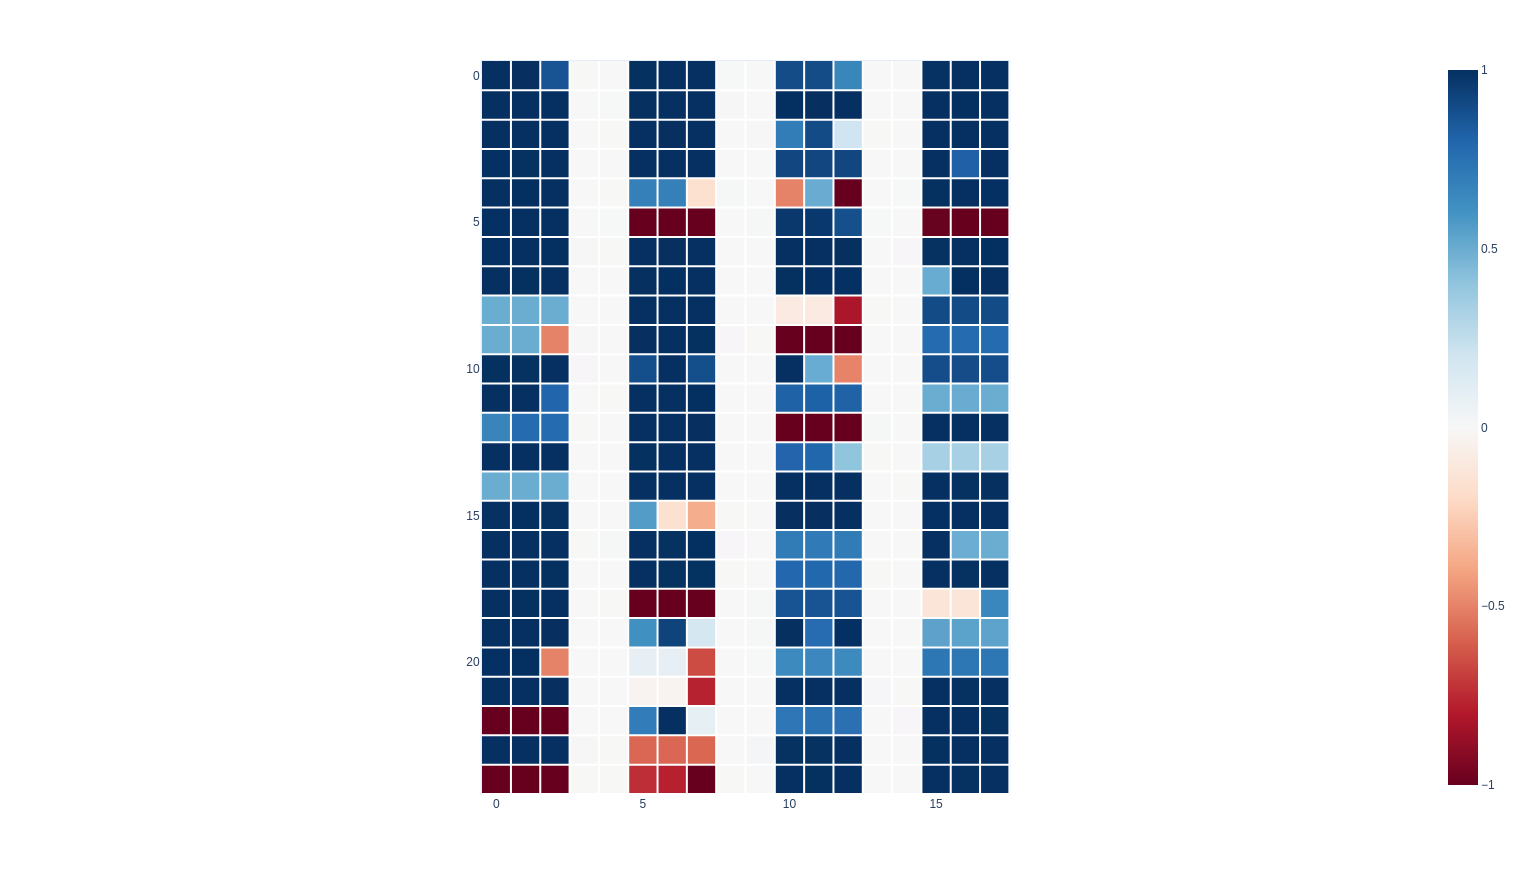

In [143]:
hm = pd.DataFrame(A)

cell_size = 35
row_title_width = 300
width = cell_size*len(hm.columns) + row_title_width
height = cell_size*len(hm.index)

fig = px.imshow(hm, width=width, height=height, color_continuous_scale='RdBu')

for i in range(len(hm.columns)):
    fig.add_shape(type="line", x0=0.5 + i, y0=-0.5, x1=0.5 + i, y1=len(hm.index) - 0.5, line=dict(color="white", width=2))

for i in range(len(hm.index)):
    fig.add_shape(type="line", x0=-0.5, y0=0.5 + i, x1=len(hm.columns) - 0.5, y1=0.5 + i, line=dict(color="white", width=2))

fig.show()